# Forecasting Telecommunication Client Churn

## Table of Contents <a id='back'></a>

* [1. Introduction](#intro)
* [2. Initiation](#init)
* [3. Data Validation](#overview)
	* [3.1. Understanding Data](#exp)
	* [3.2. Cleaning Data](#clean)
    * [3.3. Plots](#plot)
* [4. Model Development](#train)
	* [4.1. Preprocessing](#prep)
	* [4.2. Develop Model](#dev)
    * [4.3. Model Evaluation](#eval)
* [5. General Conclusion](#end)

## 1. Introduction <a id='intro'></a>

### 1.1. Project Description

The telecommunications operator named Interconnect wants to forecast their clients' churn rate. If it is known that a client plans to stop using the service, they will be offered a promotional code and special package options. The marketing team of Interconnect has collected some personal data of the clients, including information about their chosen data packages and contracts.

### 1.2. Objectives

Create a model to predict clients churn possibility with minimum ROC AUC score of 0.88.

### 1.3. Data Description

The data consists of several files from different sources:
* contract.csv — contract information
* personal.csv — client's personal data
* internet.csv — information about Internet services
* phone.csv — information about telephone services

### 1.4. Methodology

Steps taken in this research are:
1. Data Validation
 1. Data Understanding
 2. Data Cleaning
 3. Visualization
2. Model Development
3. Model Evaluation
4. Conclusion

[back to table of contents](#back)

## 2. Initiation <a id='init'></a>

In [1]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
from datetime import date

In [3]:
# set random seed for reproducibility
np.random.seed(1234)

# ignore warnings
warnings.filterwarnings('ignore')

In [4]:
# import datasets
contract = pd.read_csv('datasets/contract.csv')
internet = pd.read_csv('datasets/internet.csv')
personal = pd.read_csv('datasets/personal.csv')
phone = pd.read_csv('datasets/phone.csv')

[back to table of contents](#back)

## 3. Data Validation <a id='overview'></a>

### 3.1. Understanding Data <a id='exp'></a>

#### 3.1.1. Individual Dataset

##### 3.1.1.1. Contract

In [5]:
# show first few rows of contract table
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
# show contract dataset basic info
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
# count duplicated observation in contract dataset
contract.duplicated(subset='customerID').sum()

0

In [8]:
# show contract dataset basic statistics summary
contract.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


No missing values, no duplicated individual, and no redundant columns. `BeginDate` should be in datetime format and `TotalCharges` should be in float.

##### 3.1.1.2. Internet

In [9]:
# show first few rows of internet table
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [10]:
# show internet dataset basic info
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
# count duplicated observation in internet dataset
internet.duplicated(subset='customerID').sum()

0

In [12]:
# show internet dataset basic statistics summary
internet.describe().T

,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


No missing values, no duplicated individual, and no redundant columns. All columns are in the right datatype.

##### 3.1.1.3. Personal

In [13]:
# show first few rows of personal table
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [14]:
# show personal dataset basic info
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [15]:
# count duplicated observation in personal dataset
personal.duplicated(subset='customerID').sum()

0

In [16]:
# show personal dataset basic statistics summary
personal.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0


No missing values, no duplicated individual, and no redundant columns. All columns are in the right datatype.

##### 3.1.1.4. Phone

In [17]:
# show first few rows of phone table
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [18]:
# show phone dataset basic info
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [19]:
# count duplicated observation in phone dataset
phone.duplicated(subset='customerID').sum()

0

In [20]:
# show phone dataset basic statistics summary
phone.describe().T

,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390


No missing values, no duplicated individual, and no redundant columns. All columns are in the right datatype.

#### 3.1.2. Merged Dataset

Merged all datasets using inner join so that it results in only individuals that have data in all columns.

In [21]:
# merge datasets
df = contract.merge(internet, on='customerID').merge(personal, on='customerID').merge(phone, on='customerID')

In [22]:
# show merged dataset basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4835 non-null   object 
 1   BeginDate         4835 non-null   object 
 2   EndDate           4835 non-null   object 
 3   Type              4835 non-null   object 
 4   PaperlessBilling  4835 non-null   object 
 5   PaymentMethod     4835 non-null   object 
 6   MonthlyCharges    4835 non-null   float64
 7   TotalCharges      4835 non-null   object 
 8   InternetService   4835 non-null   object 
 9   OnlineSecurity    4835 non-null   object 
 10  OnlineBackup      4835 non-null   object 
 11  DeviceProtection  4835 non-null   object 
 12  TechSupport       4835 non-null   object 
 13  StreamingTV       4835 non-null   object 
 14  StreamingMovies   4835 non-null   object 
 15  gender            4835 non-null   object 
 16  SeniorCitizen     4835 non-null   int64  


[back to table of contents](#back)

### 3.2. Cleaning Data <a id='clean'></a>

Because this is a classification problem, `EndDate` will be changed to 0, for 'No' values and 1 for other values in the column.

In [23]:
# change enddate to churn indicator
df['EndDate'] = df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

`TotalCharges` column is changed to float.

In [24]:
# change totalcharges to numerical
df['TotalCharges'] = df['TotalCharges'].str.strip()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df['TotalCharges'] = df['TotalCharges'].astype('float32')
df['TotalCharges'].dtype

dtype('float32')

In [25]:
# show missing values of totalcharges
df[df['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
663,5709-LVOEQ,2020-02-01,0,Two year,No,Mailed check,80.85,NaN,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
4573,4075-WKNIU,2020-02-01,0,Two year,No,Mailed check,73.35,NaN,DSL,No,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes
4630,2775-SEFEE,2020-02-01,0,Two year,Yes,Bank transfer (automatic),61.90,NaN,DSL,Yes,Yes,No,Yes,No,No,Male,0,No,Yes,Yes


There are several missing value, this is because there is no charges. Change it to 0.

In [26]:
# fill missing values with 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)

Change `BeginDate` to datetime.

In [27]:
# change begindate to datetime format
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['BeginDate'].dtype

dtype('<M8[ns]')

Change column names to lowercase.

In [28]:
# change column names to lowercase.
df.columns = df.columns.str.lower()
df.columns

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'gender', 'seniorcitizen', 'partner',
       'dependents', 'multiplelines'],
      dtype='object')

Perform feature engineering by converting begindate into distance from maximum date (1 Feb 2020).

In [29]:
# make new variable, duration using begindate column
df['duration'] = df['begindate'].dt.date.max() - df['begindate'].dt.date
df['duration'] = df['duration'].dt.total_seconds() / (24*60**2)
df['duration'] = df['duration'].astype('float32')

In [30]:
# show first few rows of the final dataset
df.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,duration
0,5575-GNVDE,2017-04-01,0,One year,No,Mailed check,56.95,1889.500000,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,1036.0
1,3668-QPYBK,2019-10-01,1,Month-to-month,Yes,Mailed check,53.85,108.150002,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,123.0
2,9237-HQITU,2019-09-01,1,Month-to-month,Yes,Electronic check,70.70,151.649994,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,153.0
3,9305-CDSKC,2019-03-01,1,Month-to-month,Yes,Electronic check,99.65,820.500000,Fiber optic,No,...,Yes,No,Yes,Yes,Female,0,No,No,Yes,337.0
4,1452-KIOVK,2018-04-01,0,Month-to-month,Yes,Credit card (automatic),89.10,1949.400024,Fiber optic,No,...,No,No,Yes,No,Male,0,No,Yes,Yes,671.0


[back to table of contents](#back)

### 3.3. Plots <a id='plot'></a>

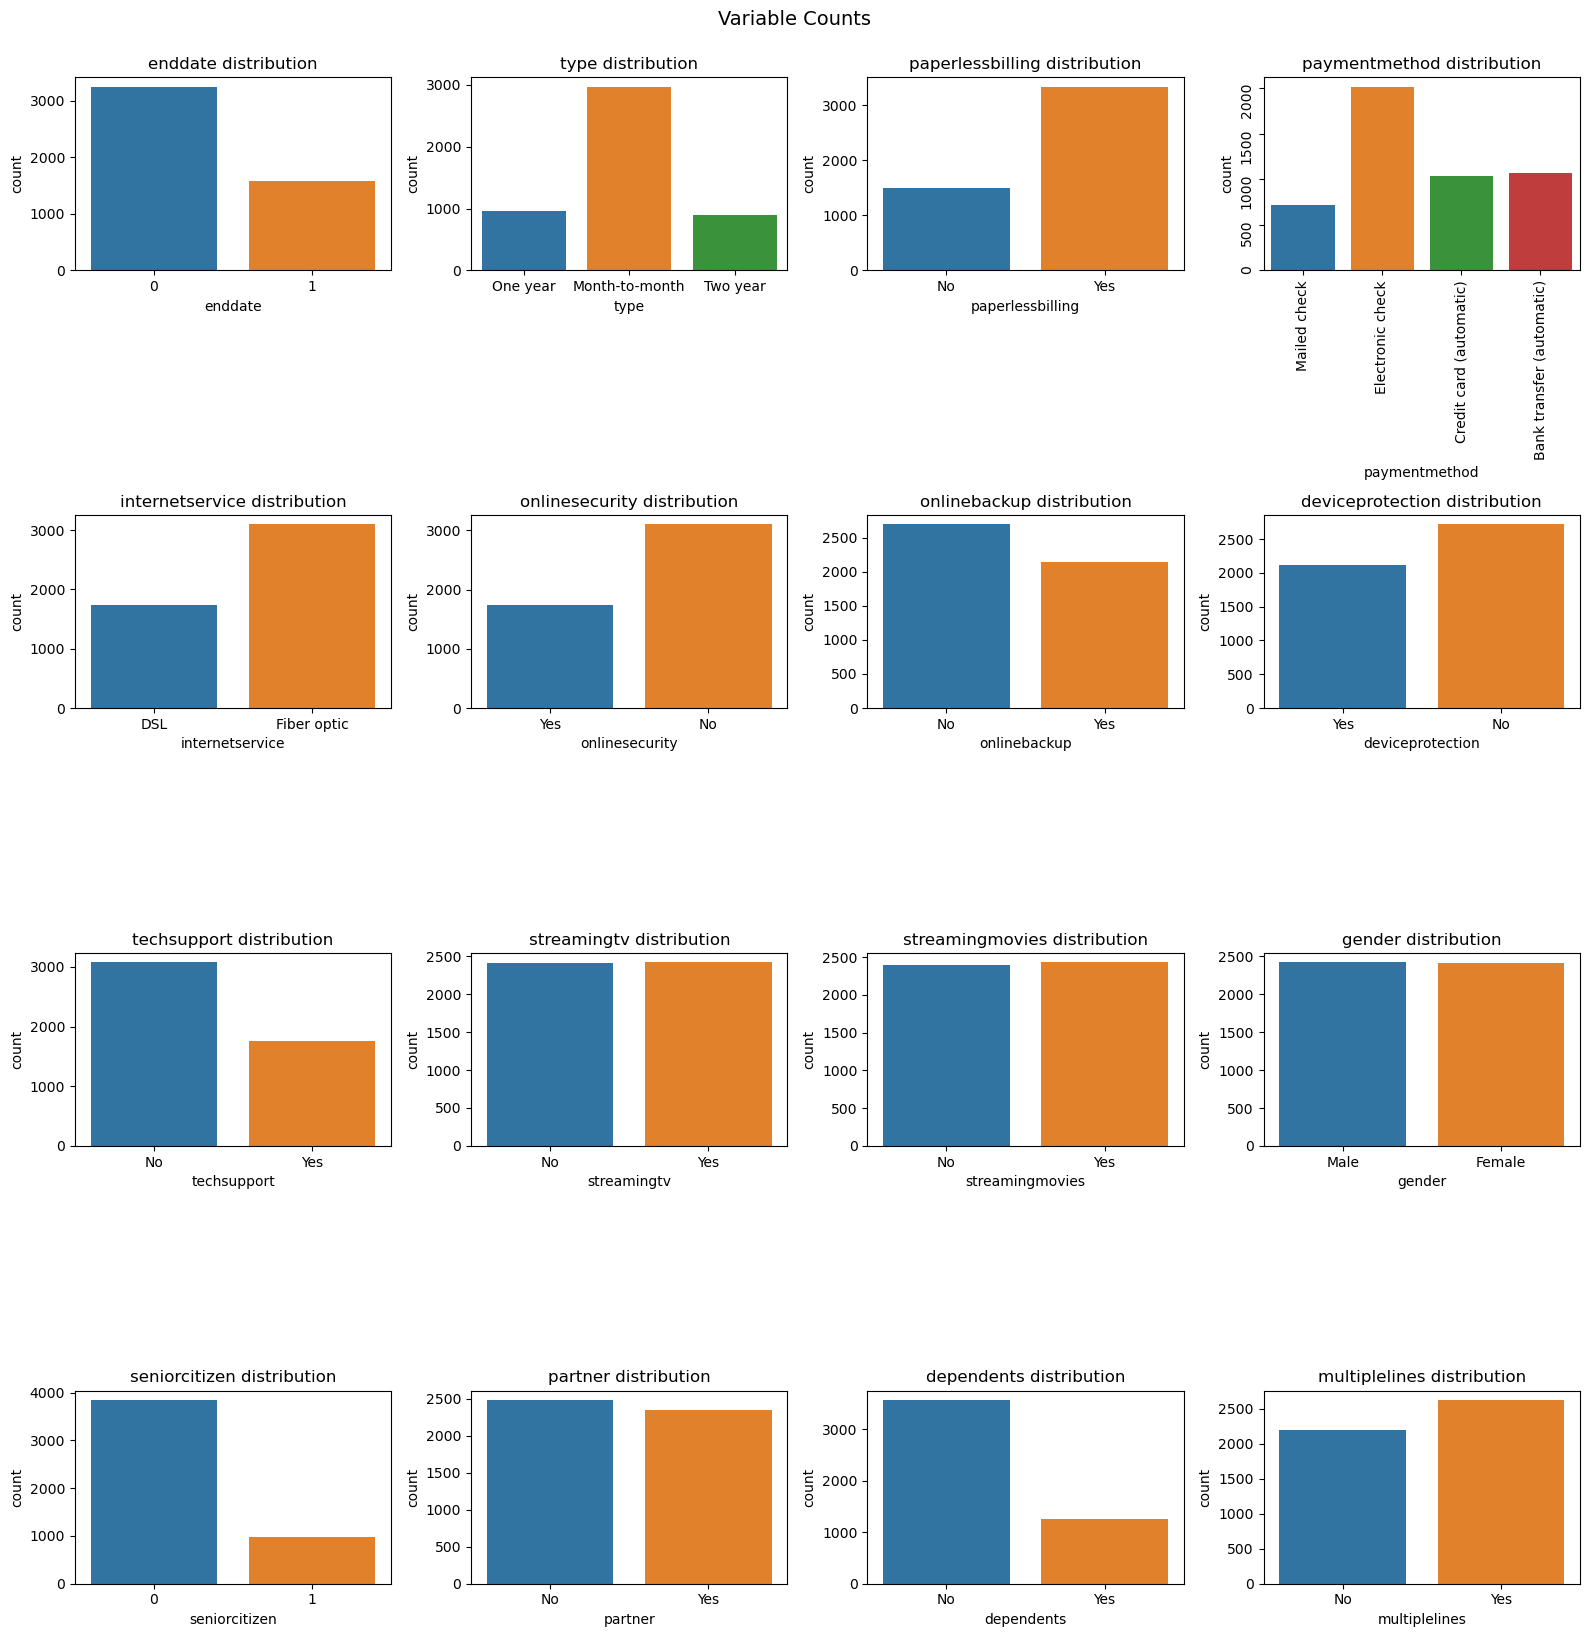

In [31]:
# make barplot for all categorical data
categorical = ['enddate', 'type', 'paperlessbilling', 'paymentmethod', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
               'streamingtv', 'streamingmovies', 'gender', 'seniorcitizen', 'partner',
               'dependents', 'multiplelines']

fig, ax = plt.subplots(4, 4, figsize=(16,16))
for i, col in enumerate(categorical):
    sns.countplot(data=df, x=col, ax=ax[i//4][i%4]).set(title = col + ' distribution')

ax[0][3].tick_params(rotation=90)
fig.tight_layout()
fig.suptitle('Variable Counts', y=1.02, fontsize=14)
plt.show()

There is a class imbalance in the target column.

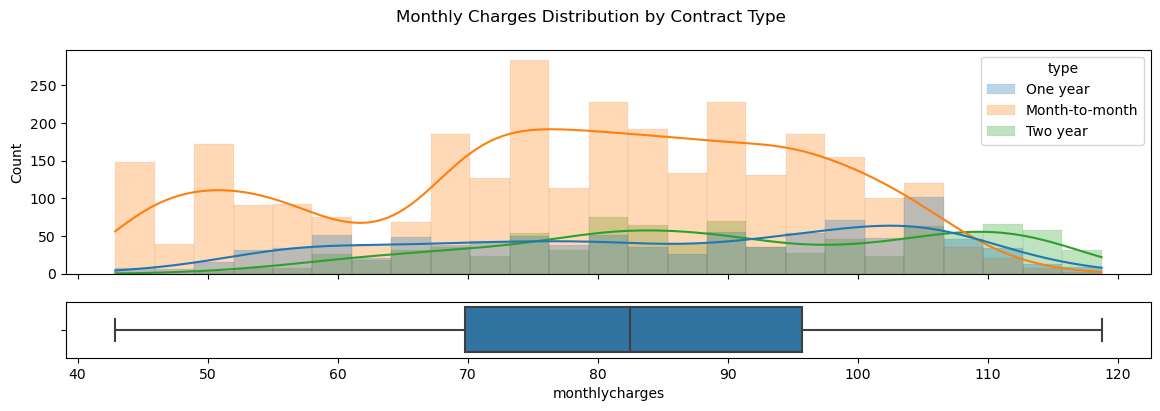

In [32]:
# make histogram for monthly charges by contract types
fig, ax = plt.subplots(2,1,figsize=(14,4),gridspec_kw={'height_ratios':[2,0.5]}, sharex=True)
sns.histplot(data=df, x='monthlycharges', hue='type', alpha=0.3, linewidth=0.03, kde=True, ax=ax[0])
sns.boxplot(data=df, x='monthlycharges', ax=ax[1])
fig.suptitle('Monthly Charges Distribution by Contract Type')
plt.show()

Monthly charges for those with month-to-month contract is smaller than those with one year and two year contract.

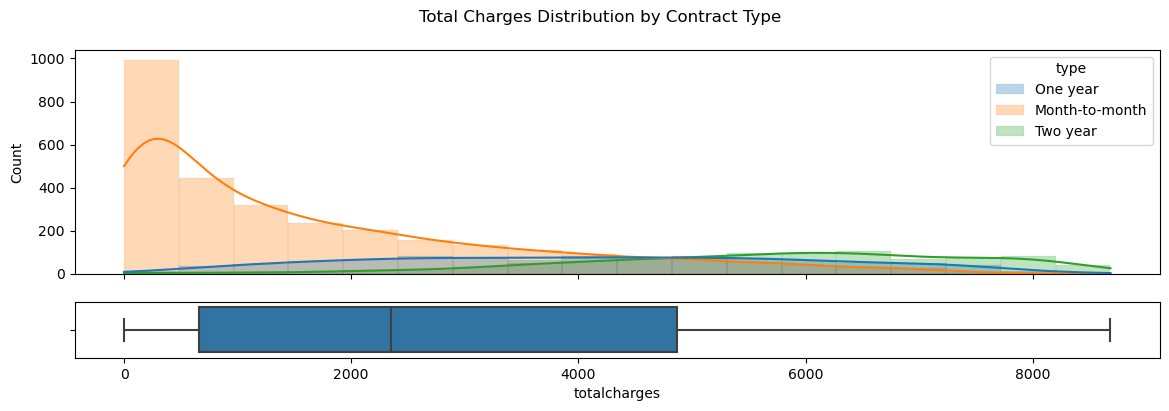

In [33]:
# make histogram for total charges by contract types
fig, ax = plt.subplots(2,1,figsize=(14,4),gridspec_kw={'height_ratios':[2,0.5]}, sharex=True)
sns.histplot(data=df, x='totalcharges', hue='type', alpha=0.3, linewidth=0.03, kde=True, ax=ax[0])
sns.boxplot(data=df, x='totalcharges', ax=ax[1])
fig.suptitle('Total Charges Distribution by Contract Type')
plt.show()

Total charges for those with month-to-month contract is smaller than those with one year and two year contract.

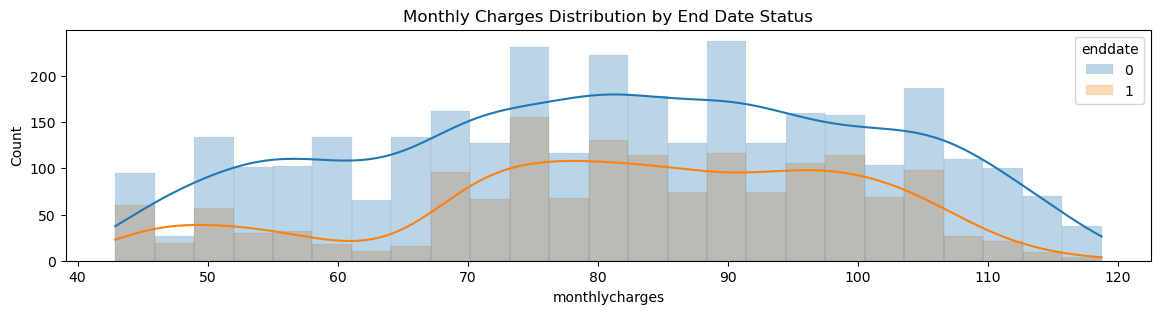

In [34]:
# make histogram for monthly charges by churn indicator
plt.figure(figsize=(14,3))
sns.histplot(data=df, x='monthlycharges', hue='enddate', alpha=0.3, linewidth=0.03, kde=True).set(title = 'Monthly Charges Distribution by End Date Status')
plt.show()

Not much difference in monthly charges between those who have churned and haven't churned.

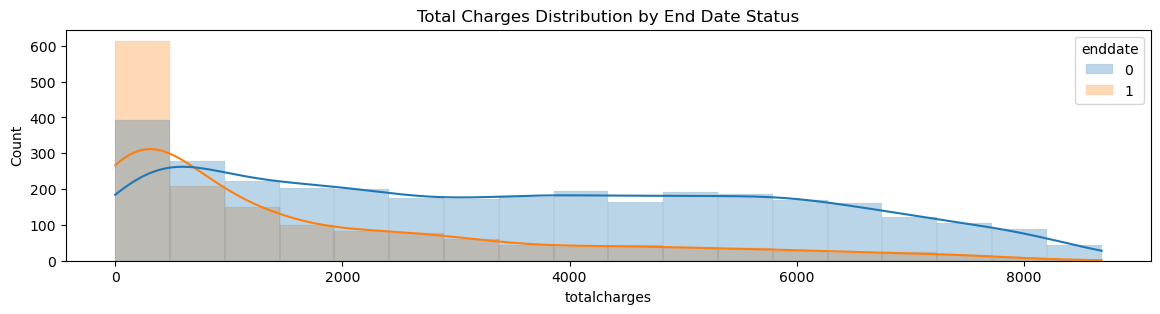

In [35]:
# make histogram for total charges by churn indicator
plt.figure(figsize=(14,3))
sns.histplot(data=df, x='totalcharges', hue='enddate', alpha=0.3, linewidth=0.03, kde=True).set(title = 'Total Charges Distribution by End Date Status')
plt.show()

Total charges for those who have churned is smaller than those who haven't.

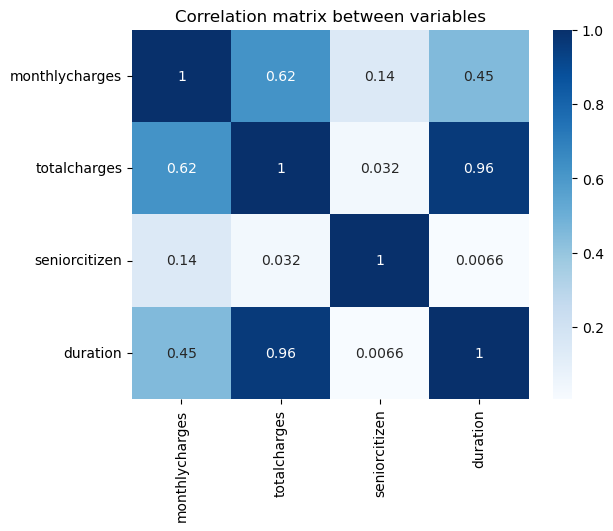

In [36]:
# make heatmap to show correlation between variables
sns.heatmap(df.drop('enddate', axis=1).corr(), annot=True, cmap='Blues').set(title='Correlation matrix between variables')
plt.show()

`totalcharges` and `duration` has strong correlation.<br>
`totalcharges` and `monthlycharges` has moderately strong correlation.<br>
`duration` and `monthlycharges` has moderate correlation.

[back to table of contents](#back)

## 4. Model Development <a id='train'></a>

In [37]:
# import libraries for model development
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

In [38]:
# instantiate dictionary for scores
roc_auc_scores_train = {}
roc_auc_scores_valid = {}
accuracy_scores_train = {}
accuracy_scores_valid = {}
f1_scores_train = {}
f1_scores_valid = {}

### 4.1. Preprocessing <a id='prep'></a>

Label encode categorical variables.

In [39]:
# list categorical columns for label encoding
categorical = ['type', 'paperlessbilling', 'paymentmethod', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
               'streamingtv', 'streamingmovies', 'gender', 'seniorcitizen', 'partner',
               'dependents', 'multiplelines']

In [40]:
# instantiate label encoder
encoder = LabelEncoder()

# label encode all categorical columns
for col in categorical:
    df[col] = encoder.fit_transform(df[col])

Split data and select these data for features:
'type', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'gender', 'seniorcitizen', 'partner', 'dependents', 'multiplelines'.

`totalcharges` is dropped because it has high correlation with `duration` and `monthlycharges`.

In [41]:
# split dataset into features and target
X = df.drop(['begindate','customerid','enddate'], axis=1)
y = df['enddate']

In [42]:
# split dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1234)

Upsample using SMOTE method.

In [43]:
# upsample using SMOTE method
smote = SMOTE(random_state=1234)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [44]:
# show counts for target
y_train.value_counts()

0    2599
1    2599
Name: enddate, dtype: int64

Target class has been balanced.

Scale numerical variables.

In [45]:
# instantiate scaler
scaler = StandardScaler()

# scale numerical features
X_train[['duration','monthlycharges','totalcharges']] = scaler.fit_transform(X_train[['duration','monthlycharges','totalcharges']])
X_valid[['duration','monthlycharges','totalcharges']] = scaler.transform(X_valid[['duration','monthlycharges','totalcharges']])

[back to table of contents](#back)

### 4.2. Develop Model <a id='dev'></a>

In [46]:
# create dict to store models settings
model_dict = {'name' : ['LogisticRegression',
                        'DecisionTreeClassifier',
                        'RandomForestClassifier',
                        'LGBMClassifier',
                        'CatBoostClassifier'],
              'model' : [LogisticRegression(),
                         DecisionTreeClassifier(random_state=1234),
                         RandomForestClassifier(random_state=1234),
                         LGBMClassifier(random_state=1234, verbose=-1),
                         CatBoostClassifier(random_state=1234, verbose=0)],
              'params' : [{'C' : np.logspace(-3,0,4)},
                          {'max_depth' : np.arange(1,15),
                           'min_samples_leaf' : [1,2,5,8]},
                          {'max_depth' : np.arange(1,15),
                           'n_estimators' : np.arange(1,62,10),
                           'min_samples_leaf' : [1,2,5,8]},
                          {'max_depth' : np.arange(1,15),
                           'n_estimators' : np.arange(1,62,10),
                           'learning_rate' : np.logspace(-3,0,4)},
                          {'max_depth' : np.arange(1,5),
                           'n_estimators' : np.arange(40,62,10),
                           'learning_rate' : np.logspace(-2,0,3)}]}

In [47]:
# instantiate KFold to ensure producibility
cv = KFold(n_splits=5, shuffle=True, random_state=1234)

LogisticRegression
{'C': 1.0}
Best score = 0.8827096922302209



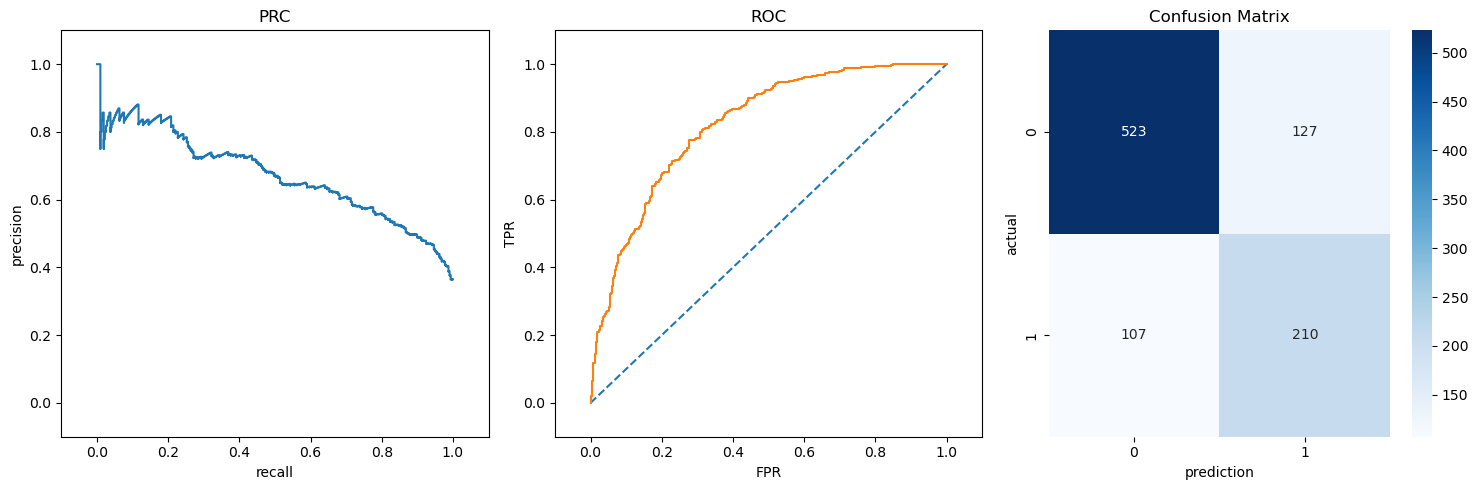

DecisionTreeClassifier
{'max_depth': 14, 'min_samples_leaf': 8}
Best score = 0.8740109556632001



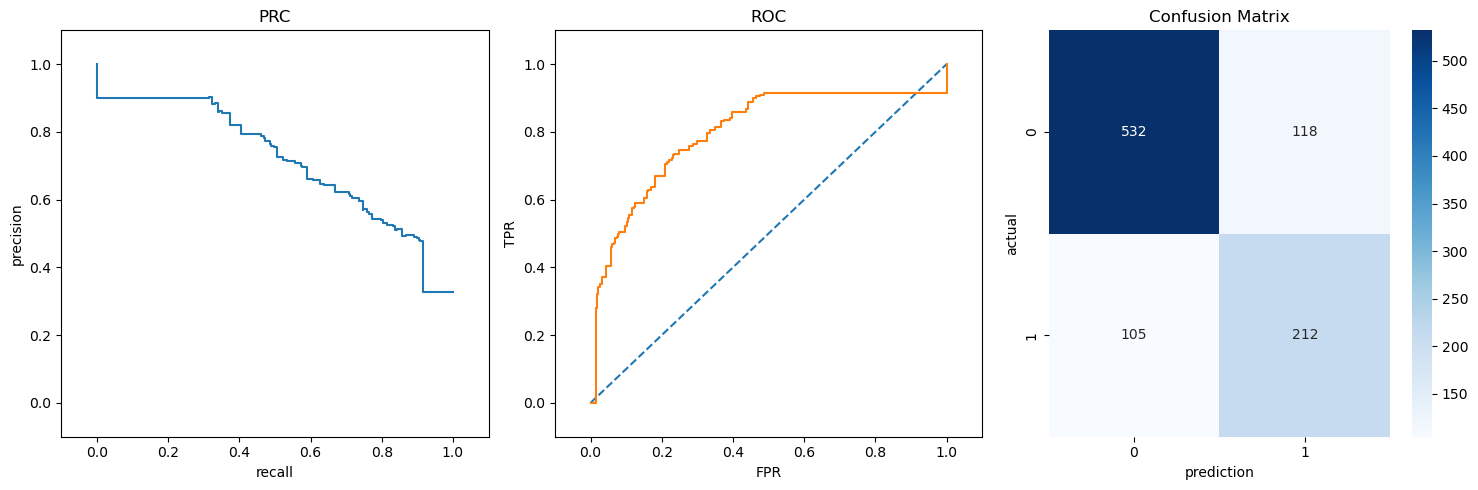

RandomForestClassifier
{'max_depth': 14, 'min_samples_leaf': 1, 'n_estimators': 61}
Best score = 0.911764429164647



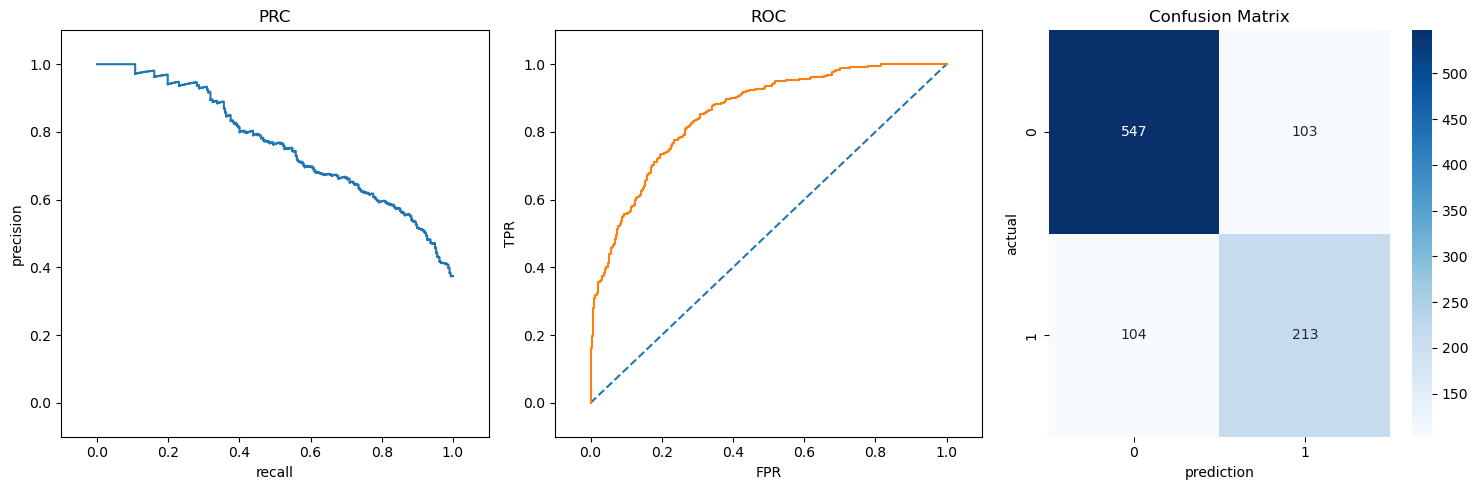

LGBMClassifier
{'learning_rate': 1.0, 'max_depth': 14, 'n_estimators': 61}
Best score = 0.9599610792741233



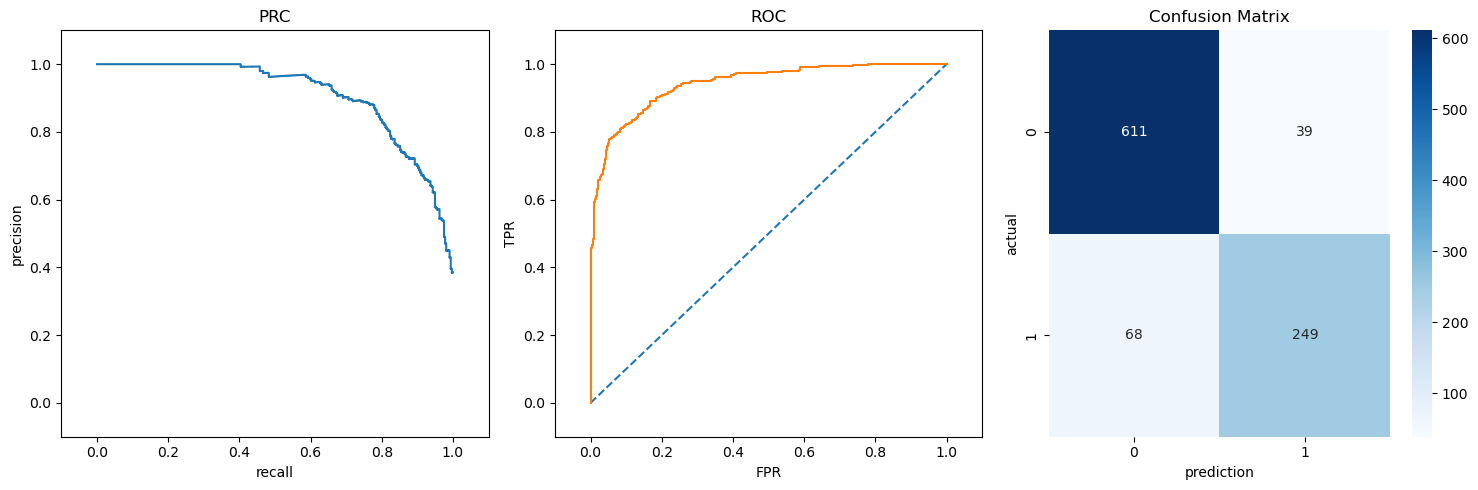

CatBoostClassifier
{'learning_rate': 1.0, 'max_depth': 4, 'n_estimators': 60}
Best score = 0.9483014398317501



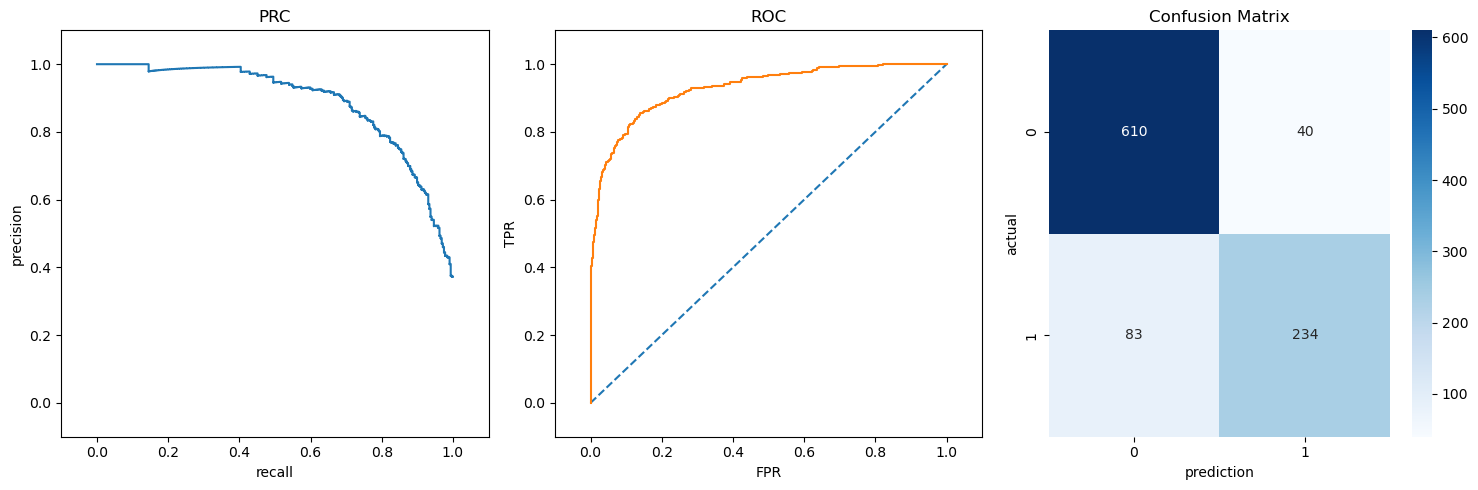

In [48]:
for i in range(len(model_dict['name'])):
    
    # search for the best hyperparameters
    grid = GridSearchCV(model_dict['model'][i], param_grid=model_dict['params'][i], cv=cv, scoring='roc_auc')
    
    # fit grid with train datasets
    grid.fit(X_train, y_train)
    
    # print best hyperparameters and scores for each model
    print(model_dict['name'][i])
    print(grid.best_params_)
    print('Best score =', grid.best_score_)
    print()
    
    # predict value and probability on training set with best estimator
    y_pred_train = grid.predict(X_train)
    y_pred_proba_train = grid.predict_proba(X_train)[:,1]
    
    # store scores
    roc_auc_scores_train[model_dict['name'][i]] = roc_auc_score(y_train, y_pred_proba_train)
    accuracy_scores_train[model_dict['name'][i]] = accuracy_score(y_train, y_pred_train)
    f1_scores_train[model_dict['name'][i]] = f1_score(y_train, y_pred_train)
    
    # predict value and probability on validation set with best estimator
    y_pred_valid = grid.predict(X_valid)
    y_pred_proba_valid = grid.predict_proba(X_valid)[:,1]
    
    # store scores
    roc_auc_scores_valid[model_dict['name'][i]] = roc_auc_score(y_valid, y_pred_proba_valid)
    accuracy_scores_valid[model_dict['name'][i]] = accuracy_score(y_valid, y_pred_valid)
    f1_scores_valid[model_dict['name'][i]] = f1_score(y_valid, y_pred_valid)    
    
    # generate PRC, and ROC Curve values
    precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba_valid)
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba_valid)
    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    
    #plot PRC
    ax[0].step(recall, precision, where='post')
    ax[0].set(title='PRC', xlabel='recall', ylabel='precision')
    ax[0].axis([-0.1,1.1,-0.1,1.1])
    
    #plot ROC
    ax[1].plot([0,1],[0,1],'--')
    ax[1].step(fpr, tpr, where='post')
    ax[1].set(title='ROC', xlabel='FPR', ylabel='TPR')
    ax[1].axis([-0.1,1.1,-0.1,1.1])
    
    #plot confusion matrix
    sns.heatmap(confusion_matrix(y_valid, y_pred_valid).round(0).astype('int'), annot=True, fmt=".0f", cmap='Blues', ax=ax[2])
    ax[2].set(title='Confusion Matrix', xlabel='prediction', ylabel='actual')
    
    plt.tight_layout()
    plt.show()

[back to table of contents](#back)

### 4.3. Model Evaluation <a id='eval'></a>

In [49]:
# store all scores to one dataframe
scores = pd.DataFrame([roc_auc_scores_train, roc_auc_scores_valid, accuracy_scores_train, accuracy_scores_valid, f1_scores_train, f1_scores_valid],
                      index=['roc_auc_train', 'roc_auc_valid', 'acc_train', 'acc_valid', 'f1_train', 'f1_valid']).T
scores.sort_values(by='roc_auc_valid', ascending=False)

,roc_auc_train,roc_auc_valid,acc_train,acc_valid,f1_train,f1_valid
LGBMClassifier,1.000000,0.941407,1.000000,0.889349,1.000000,0.823140
CatBoostClassifier,0.979827,0.928129,0.929204,0.872802,0.927843,0.791878
RandomForestClassifier,0.998148,0.854455,0.974028,0.785936,0.974676,0.672986
DecisionTreeClassifier,0.950872,0.824416,0.869373,0.769390,0.869096,0.655332
LogisticRegression,0.885243,0.821014,0.795306,0.758014,0.796090,0.642202


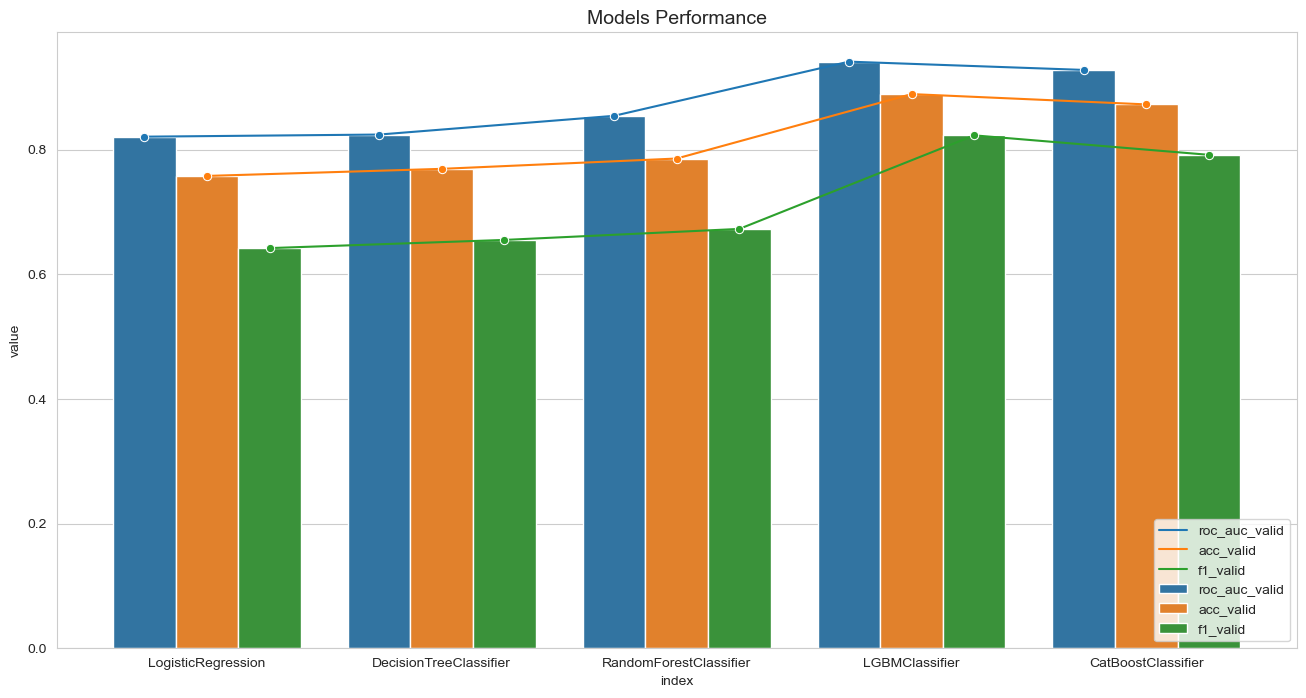

In [50]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,8))
bars = sns.barplot(data=scores[['roc_auc_valid', 'acc_valid', 'f1_valid']].reset_index().melt(id_vars='index'), x='index', y='value', hue='variable')
bar_positions = [bar.get_x() + bar.get_width() / 2 for bar in bars.patches]
sns.lineplot(data=scores[['roc_auc_valid', 'acc_valid', 'f1_valid']].reset_index().melt(id_vars='index'), x=bar_positions, y='value', marker='o', hue='variable')
plt.title('Models Performance', fontsize=14)
plt.legend(loc=4)
plt.show()

In [51]:
# predict using lgbm classifier with best hyperparameters
m = LGBMClassifier(learning_rate=1, max_depth=14, n_estimators=61, random_state=1234)
m.fit(X_train, y_train)

LGBMClassifier(learning_rate=1, max_depth=14, n_estimators=61,
               random_state=1234)

In [52]:
# create feature importance dataframe
feature_imp = pd.DataFrame([m.feature_name_, m.feature_importances_], index=['name','score']).T

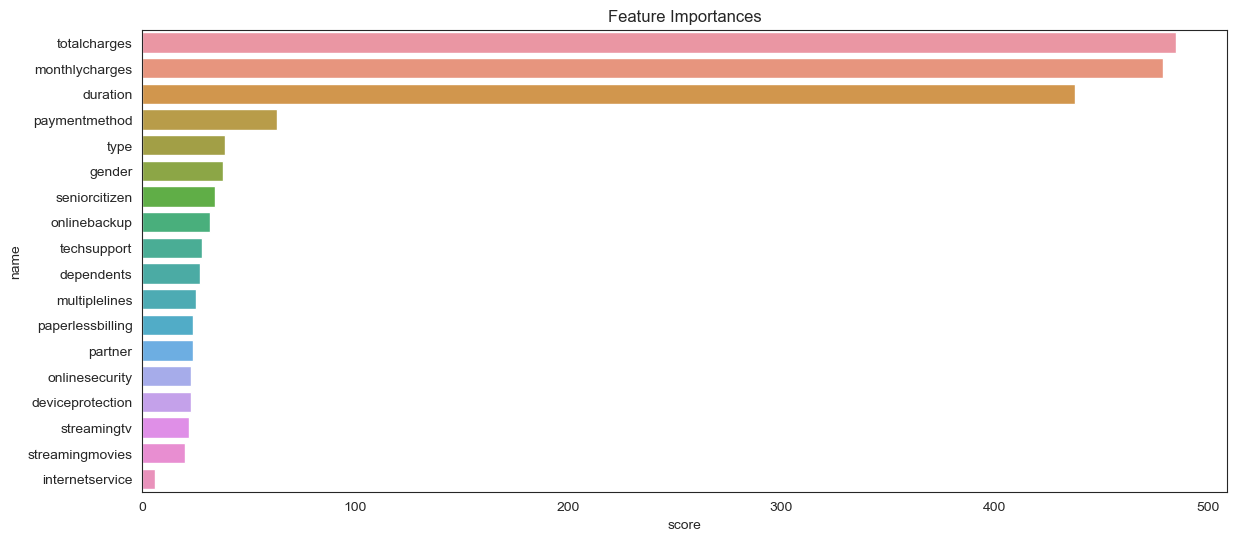

In [53]:
# plot feature importances
sns.set_style('white')
plt.figure(figsize=(14,6))
sns.barplot(data=feature_imp.sort_values(by='score', ascending=False), x='score', y='name').set(title='Feature Importances')
plt.show()

Total Charges have the most influence out of all, followed by monthly charges, and duration. These features outperform others on large margins.

[back to table of contents](#back)

## 5. General Conclusion <a id='end'></a>

**The steps taken in this project are as follows:**
1. Data validation and exploration - This step involved validating the data for correct data types, checking for duplicates, missing values, and outliers. Inconsistent data was handled based on the type of error to ensure optimal model training and avoid distorting results or hindering model training. Data exploration was also conducted to understand data distribution and variable correlations.
2. Model development - In this stage, data preprocessing was performed, including converting categorical data into numerical format, splitting the data into training and validation datasets, balancing the target classes, and standardizing numerical data. These steps were taken to enable training of categorical data on all models, prevent prediction bias toward one class, and ensure consistent scaling across data with varying ranges. Following data preprocessing, classification models such as Logistic Regression, Decision Tree Classifier, Random Forest Classifier, LGBM Classifier, and Cat Boost Classifier were trained. Hyperparameters were adjusted to find the most suitable settings for optimal results based on the ROC-AUC metric.
3. Model evaluation - The results obtained from each model with the best hyperparameters were compared on three metrics: ROC-AUC, Accuracy, and F1 scores. The comparisons were made to identify a model with specific hyperparameters that provided the best performance on the primary metric without sacrificing other metrics significantly. Additionally, feature comparisons were conducted to identify the most impactful and least impactful features, allowing for inclusion or exclusion in model training or production to optimize training and prediction efficiency.

**Key steps taken to complete this task:**
1. Data cleaning involved converting the target column, `EndDate`, into a binary indicator (0 or 1). The `TotalCharges` column was cleaned by removing spaces and converted to a numeric column. `BeginDate` was transformed into a datetime format and used to create a new feature, customer subscription duration.
2. Data preprocessing included encoding categorical variables, separating the dataset into feature and target columns, and further splitting it into training and validation datasets. The dataset was upsampled using SMOTE to balance the target classes. Numeric columns were scaled using a standard scaler to handle any outliers.
3. Model training involved using Grid Search CV to find the best hyperparameters for several models based on the ROC-AUC score. The models were then compared using classification metrics (ROC-AUC, Accuracy, and F1 scores).

**Final model:**

Among all the trained models, the **LGBM Classifier** emerged as the best model. It achieved an **ROC-AUC score of 0.94, an accuracy score of 0.88, and an F1 score of 0.82**. The high ROC-AUC score indicates that the model can distinguish between positive and negative classes effectively. The most important feature for this estimator is `totalcharges`, followed by `monthlycharges` and `duration`. These features significantly outperformed others.

[back to table of contents](#back)